# Figure 4. The effect of uni- and bimodality of $\mu$ and $\beta$.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import os

In [2]:
def simulate_wealth(surnames, W0_values, mu_values, beta_values, times, groups):
    records = []
    np.random.seed(40)
    for surname, W0, mu, beta, group in zip(surnames, W0_values, mu_values, beta_values, groups):
        for t in times:
            exp_part = (1 - beta**t) * mu
            wealth = np.exp(exp_part) * W0**(beta**t)
            log_wealth = np.log(wealth)
            log_random = np.random.normal(loc=0, scale=1)
            records.append({'Surname': surname, 
                            'Group': group,
                            'Time': t, 
                            'Wealth': wealth, 
                            'log_Wealth': log_wealth, 
                            'mu': mu, 
                            'beta': beta, 
                            'W0': W0, 
                            'log_random':log_random
                            })
    return pd.DataFrame(records)

# Fixed Mu, Varying Beta

In [3]:
# Simulation parameters (As in the simulations above.)
np.random.seed(40)
n_surnames = 100
surnames = np.arange(n_surnames)

times = range(1, 21)
# Bimodal initial wealth
high_initial_wealth = np.random.lognormal(mean=10, sigma=2, size=n_surnames//2)
low_initial_wealth = np.random.lognormal(mean=-10, sigma=2, size=n_surnames//2)
initial_wealth = np.concatenate([high_initial_wealth, low_initial_wealth])

high = np.full(n_surnames//2, 'high')  
low = np.full(n_surnames//2, 'low')
groups = np.concatenate([high, low])


# Fixed mu
mu_values = np.full(n_surnames, fill_value = 0)


# Unimodal beta situation
unibeta_values = np.random.uniform(0.40, 0.50, size = n_surnames)

# Bimodal beta
beta_values_high = np.random.uniform(0, 0.2, size=n_surnames//2) 
beta_values_low = np.random.uniform(0.7, 0.9, size=n_surnames//2) 

beta_values = np.concatenate([beta_values_high, beta_values_low]) 

# Population-wise convergence value
mu_population = np.mean(mu_values)
W0_population = np.mean(initial_wealth)

beta_population = np.mean(beta_values)
unibeta_population = np.mean(unibeta_values)

# Generate Data for scenario 1
df_scenario1 = simulate_wealth(surnames, initial_wealth, mu_values, beta_values, times, groups)
population_data1 = simulate_wealth(['Population'], [W0_population], [mu_population], [beta_population], times, groups)

# Generate Data for scenario 2
df_scenario2 = simulate_wealth(surnames, initial_wealth, mu_values, unibeta_values, times, groups)
population_data2 = simulate_wealth(['Population'], [W0_population], [mu_population], [unibeta_population], times, groups)


In [4]:
def preprocess_scenario(df_scenario):
    # Create the time zero dataframe
    df_time_zero = df_scenario[['Surname', 'Group', 'W0']].drop_duplicates().copy()
    df_time_zero['Time'] = 0
    df_time_zero['Wealth'] = df_time_zero['W0']  # Set Wealth to W0
    df_time_zero['log_Wealth'] = np.log(df_time_zero['W0'])  # Set log_Wealth to log(W0)
    df_time_zero['log_random'] = 0  # For the graph, it doesn't matter

    # Concatenate and sort
    df_scenario = pd.concat([df_scenario, df_time_zero], ignore_index=True)
    df_scenario = df_scenario.sort_values(by=['Surname', 'Time']).reset_index(drop=True)

    # Add log_Wealth_Random
    df_scenario['log_Wealth_Random'] = df_scenario['log_Wealth'] + df_scenario['log_random']

    # Rank wealth
    df_scenario['Wealth_Rank'] = df_scenario.groupby('Time')['log_Wealth_Random'].rank(ascending=False, method="first")

    # Shift rank to create previous rank
    df_scenario['Wealth_Rank_Prev'] = df_scenario.groupby(['Surname'])['Wealth_Rank'].shift(1)

    # Get the first rank at Time = 1
    temp = df_scenario[df_scenario['Time'] == 1][['Surname', 'Wealth_Rank']].copy()
    temp = temp.rename(columns={'Wealth_Rank': 'Wealth_Rank_first'})
    df_scenario = pd.merge(df_scenario, temp, on='Surname', how='left')

    # Filter out Time 0 for further analysis (If needed)
    df_scenario_withoutT0 = df_scenario[df_scenario['Time'] != 0].copy()

    return df_scenario, df_scenario_withoutT0


In [5]:
df_scenario1, df_scenario1_withoutT0 = preprocess_scenario(df_scenario1)
df_scenario2, df_scenario2_withoutT0 = preprocess_scenario(df_scenario2)

In [6]:
print(df_scenario1['Wealth_Rank'].nunique(), df_scenario2['Wealth_Rank'].nunique(), df_scenario1['Surname'].nunique())

100 100 100


In [7]:
df_scenario1_withoutT0

Surname Group  Time    Wealth  log_Wealth   mu      beta           W0   
1           0  high     1  2.281351    0.824768  0.0  0.093885  6534.849563  \
2           0  high     2  1.080510    0.077433  0.0  0.093885  6534.849563   
3           0  high     3  1.007296    0.007270  0.0  0.093885  6534.849563   
4           0  high     4  1.000683    0.000683  0.0  0.093885  6534.849563   
5           0  high     5  1.000064    0.000064  0.0  0.093885  6534.849563   
...       ...   ...   ...       ...         ...  ...       ...          ...   
2095       99   low    16  0.840172   -0.174149  0.0  0.797071     0.001415   
2096       99   low    17  0.870394   -0.138809  0.0  0.797071     0.001415   
2097       99   low    18  0.895260   -0.110641  0.0  0.797071     0.001415   
2098       99   low    19  0.915588   -0.088188  0.0  0.797071     0.001415   
2099       99   low    20  0.932121   -0.070292  0.0  0.797071     0.001415   

      log_random  log_Wealth_Random  Wealth_Rank  Wealth_Rank_Prev   
1      -0.607548           0.217220         41.0              42.0  \
2      -0.126136          -0.048703         29.0              41.0   
3      -0.684606          -0.677337         38.0              29.0   
4       0.928715           0.929397         17.0              38.0   
5      -1.844401          -1.844337         63.0              17.0   
...          ...                ...          ...               ...   
2095    1.647900           1.473751          6.0              29.0   
2096    0.165549           0.026740         44.0               6.0   
2097   -0.023437          -0.134078         57.0              44.0   
2098    0.513810           0.425622         33.0              57.0   
2099    1.238920           1.168627          8.0              33.0   

      Wealth_Rank_first  
1                  41.0  
2                  41.0  
3                  41.0  
4                  41.0  
5                  41.0  
...                 ...  
2095               51.0  
2096               51.0  
2097               51.0  
2098               51.0  
2099               51.0  

[2000 rows x 13 columns]

## Bimodal beta

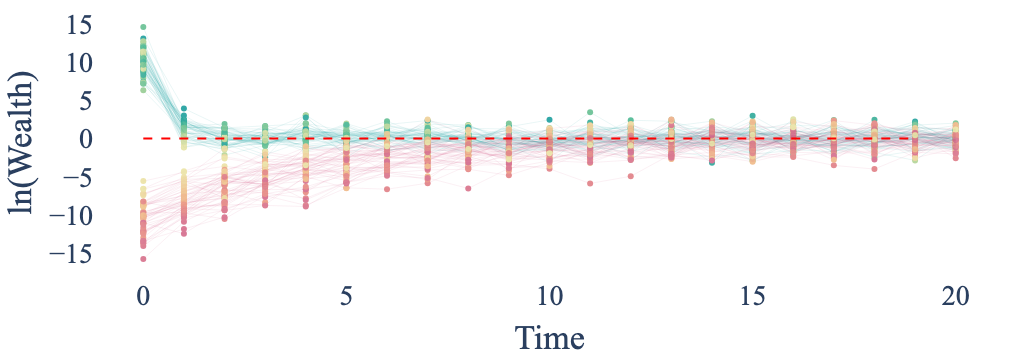

In [11]:
fig = go.Figure()

df_high = df_scenario1[df_scenario1['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario1[df_scenario1['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario1['Time'], 
    y=df_scenario1['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario1['Wealth_Rank_first'],  
        colorscale='Temps',  
        # colorbar=dict(title="Wealth Rank") 
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario1['Time'], 
                         y=population_data1['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


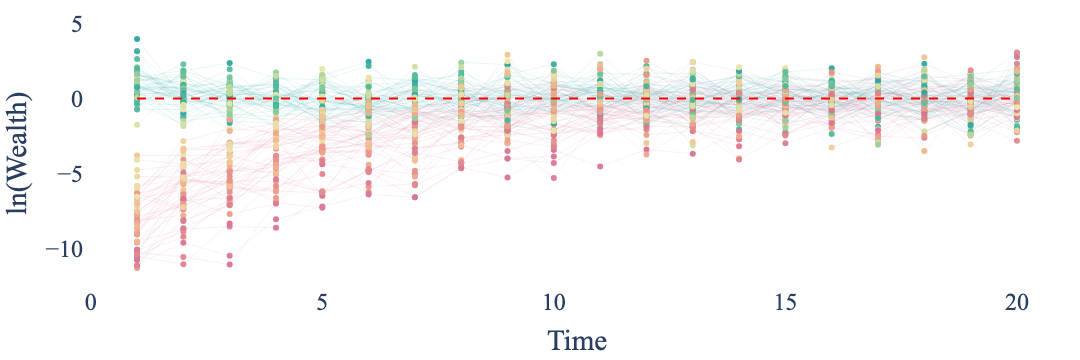

In [62]:
fig = go.Figure()

df_high = df_scenario1_withoutT0[df_scenario1_withoutT0['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario1_withoutT0[df_scenario1_withoutT0['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'],
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario1_withoutT0['Time'], 
    y=df_scenario1_withoutT0['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario1_withoutT0['Wealth_Rank_Prev'],  # Actually I should Rank them based on log_Wealth+log_random... 
        colorscale='Temps'  
        # showscale=True,  
        # colorbar=dict(title="Wealth Rank of Previous Time") 
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario1_withoutT0['Time'], 
                         y=population_data1['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 24,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


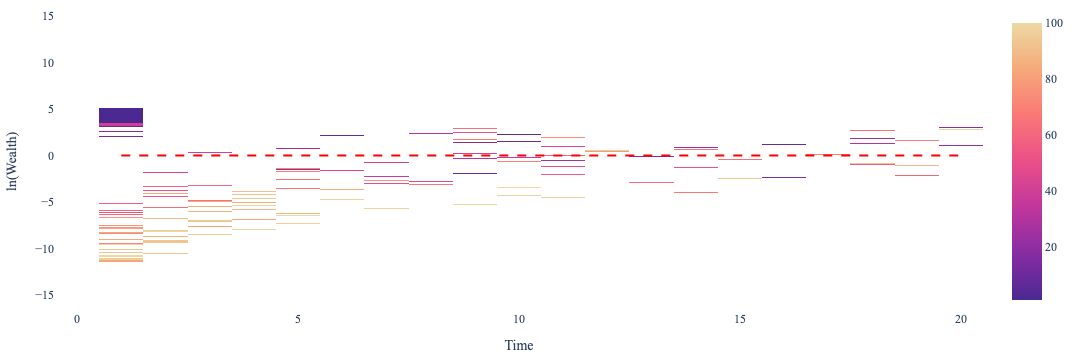

In [11]:
fig = go.Figure(data=go.Heatmap(
        z=df_scenario1['Wealth_Rank_Prev'],
        x=df_scenario1['Time'],
        y=df_scenario1['log_Wealth_Random'],
        hoverongaps=False,
        colorscale='Agsunset'))

fig.add_trace(go.Scatter(x=population_data1['Time'], 
                         y=population_data1['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


## Unimodal beta

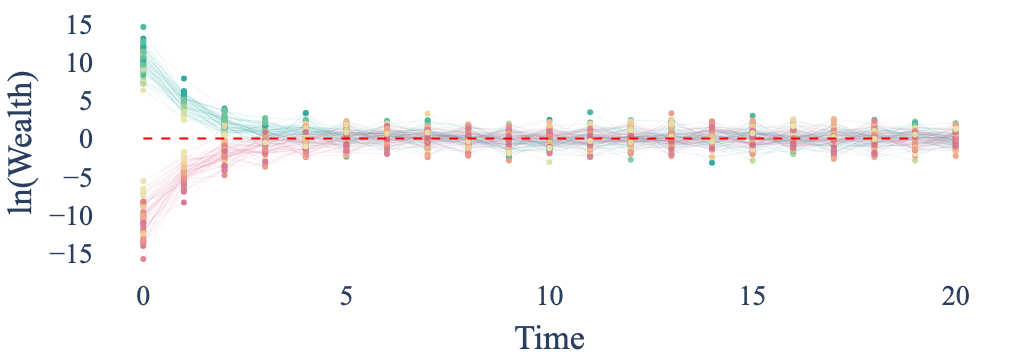

In [12]:
fig = go.Figure()


df_high = df_scenario2[df_scenario2['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario2[df_scenario2['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario2['Time'], 
    y=df_scenario2['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario2['Wealth_Rank_first'],  # Use Wealth_Rank globally
        colorscale='Temps',  # Continuous color scale
        # showscale=True,  # Display the color scale
        # colorbar=dict(title="Wealth Rank")  # Title for the color scale
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario2['Time'], 
                         y=population_data2['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size=28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


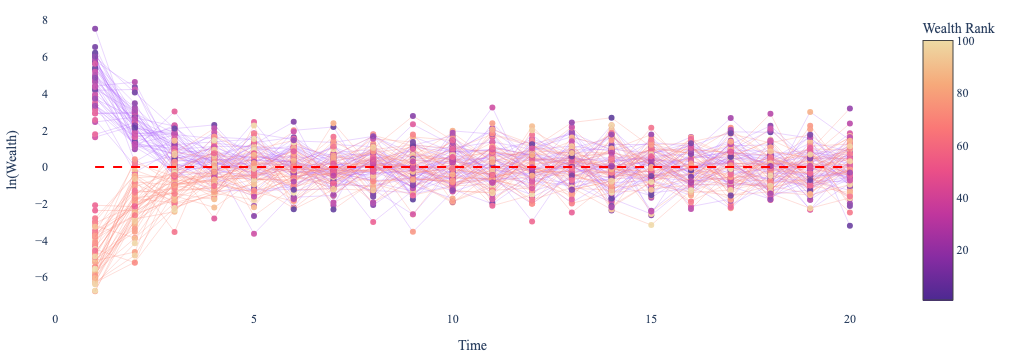

In [14]:
fig = go.Figure()


df_high = df_scenario2_withoutT0[df_scenario2_withoutT0['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.3,
        line=dict(width=0.85, color='#AB63FA')
    ))


df_low = df_scenario2_withoutT0[df_scenario2_withoutT0['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.3,
        line=dict(width=0.85, color='salmon')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario2_withoutT0['Time'], 
    y=df_scenario2_withoutT0['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario2_withoutT0['Wealth_Rank_Prev'],  # Use Wealth_Rank globally
        colorscale='Agsunset',  # Continuous color scale
        # showscale=True,  # Display the color scale
        colorbar=dict(title="Wealth Rank")  # Title for the color scale
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario2_withoutT0['Time'], 
                         y=population_data2['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


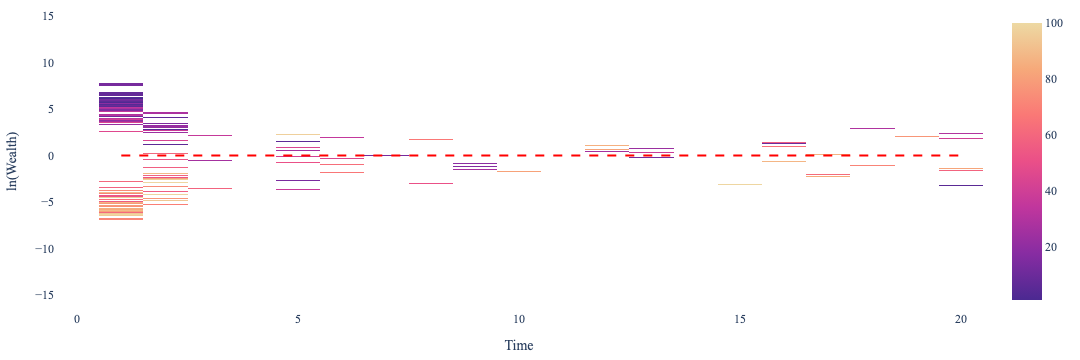

In [15]:
fig = go.Figure(data=go.Heatmap(
        z=df_scenario2['Wealth_Rank_Prev'],
        x=df_scenario2['Time'],
        y=df_scenario2['log_Wealth_Random'],
        hoverongaps=False,
        colorscale='Agsunset'))

fig.add_trace(go.Scatter(x=population_data2['Time'], 
                         y=population_data2['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


# Fixed Beta, Varying Mu

## Bimodal Mu

In [29]:
# Simulation parameters (As in the simulations above.)
np.random.seed(40)
n_surnames = 100
surnames = np.arange(n_surnames)

times = range(1, 21)
# Bimodal initial wealth
high_initial_wealth = np.random.lognormal(mean=10, sigma=2, size=n_surnames//2)
low_initial_wealth = np.random.lognormal(mean=-10, sigma=2, size=n_surnames//2)
initial_wealth = np.concatenate([high_initial_wealth, low_initial_wealth])

high = np.full(n_surnames//2, 'high')  
low = np.full(n_surnames//2, 'low')
groups = np.concatenate([high, low])

# Bimodal mu
mu_high = np.random.normal(10, 0.01, size = n_surnames//2) # For the high initial wealth 
mu_low = np.random.normal(-10, 0.01, size = n_surnames//2) # For the low initial wealth
mu_values = np.concatenate([mu_high, mu_low])

# Unimodal mu
unimu_values = np.random.normal(0, 0.01, size = n_surnames)


# Fix beta
beta_values = np.full(n_surnames, 0.45)

# Population-wise convergence value
mu_population = np.mean(mu_values)
unimu_population = np.mean(unimu_values)
W0_population = np.mean(initial_wealth)
beta_population = np.mean(beta_values)

# Generate Data for scenario 3
df_scenario3 = simulate_wealth(surnames, initial_wealth, mu_values, beta_values, times, groups)
population_data3 = simulate_wealth(['Population'], [W0_population], [mu_population], [beta_population], times, groups)

# Generate Data for scenario 4
df_scenario4 = simulate_wealth(surnames, initial_wealth, unimu_values, beta_values, times, groups)
population_data4 = simulate_wealth(['Population'], [W0_population], [unimu_population], [beta_population], times, groups)


In [30]:
df_scenario3, df_scenario3_withoutT0 = preprocess_scenario(df_scenario3)
df_scenario4, df_scenario4_withoutT0 = preprocess_scenario(df_scenario4)

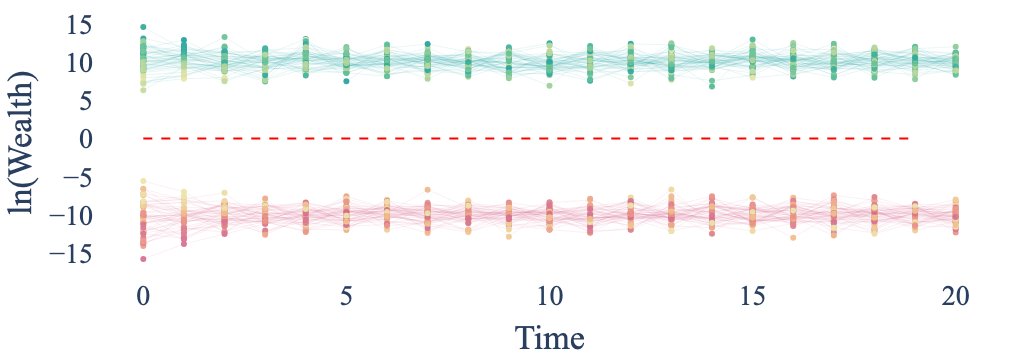

In [62]:
fig = go.Figure()

df_high = df_scenario3[df_scenario3['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario3[df_scenario3['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario3['Time'], 
    y=df_scenario3['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario3['Wealth_Rank_first'], 
        colorscale='Temps',  
        # showscale=True,  
        # colorbar=dict(title="Wealth Rank") 
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario3['Time'], 
                         y=population_data3['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))


fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size=28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


## Unimodal Mu

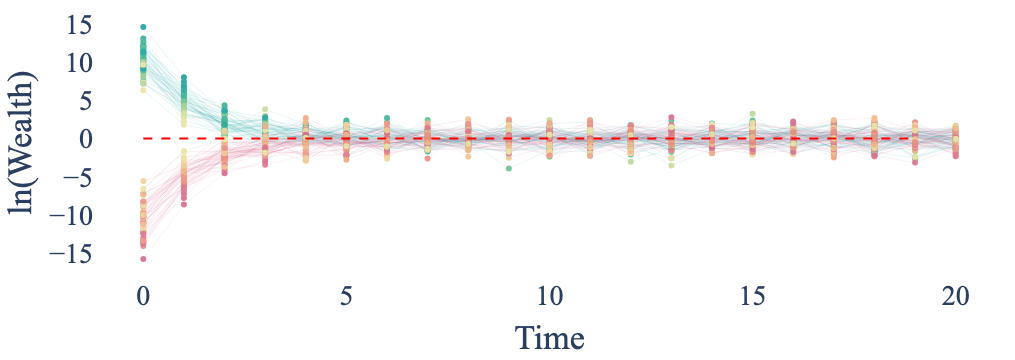

In [64]:
fig = go.Figure()


df_high = df_scenario4[df_scenario4['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario4[df_scenario4['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario4['Time'], 
    y=df_scenario4['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario4['Wealth_Rank_first'],  # Use Wealth_Rank globally
        colorscale='Temps',  
        # showscale=True,  
        # colorbar=dict(title="Wealth Rank")  
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario4['Time'], 
                         y=population_data4['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


# Varying Beta, Varying Mu

In [31]:
# Simulation parameters (As in the simulations above.)
np.random.seed(40)
n_surnames = 100
surnames = np.arange(n_surnames)

times = range(1, 21)
# Bimodal initial wealth
high_initial_wealth = np.random.lognormal(mean=10, sigma=2, size=n_surnames//2)
low_initial_wealth = np.random.lognormal(mean=-10, sigma=2, size=n_surnames//2)
initial_wealth = np.concatenate([high_initial_wealth, low_initial_wealth])

high = np.full(n_surnames//2, 'high') 
low = np.full(n_surnames//2, 'low')
groups = np.concatenate([high, low])

#------------------------------------
# Bimodal mu
mu_high = np.random.normal(10, 0.01, size = n_surnames//2) # For the high initial wealth 
mu_low = np.random.normal(-10, 0.01, size = n_surnames//2) # For the low initial wealth
mu_values = np.concatenate([mu_high, mu_low])

# Bimodal beta
beta_values_high = np.random.uniform(0, 0.2, size=n_surnames//2) 
beta_values_low = np.random.uniform(0.7, 0.9, size=n_surnames//2) 
beta_values = np.concatenate([beta_values_high, beta_values_low]) 

#------------------------------------
# Unimodal mu
unimu_values = np.random.normal(0, 0.01, size = n_surnames)

# Unimodal beta 
unibeta_values = np.random.uniform(0.40, 0.50, size = n_surnames)


#-------------------------------------
# Population-wise convergence value
mu_population = np.mean(mu_values)
W0_population = np.mean(initial_wealth)
beta_population = np.mean(beta_values)

unimu_population = np.mean(unimu_values)
unibeta_population = np.mean(unibeta_values)

#-------------------------------------
# Generate Data for scenario 5
df_scenario5 = simulate_wealth(surnames, initial_wealth, mu_values, beta_values, times, groups)
population_data5 = simulate_wealth(['Population'], [W0_population], [mu_population], [beta_population], times, groups)

# Generate Data for scenario 6
df_scenario6 = simulate_wealth(surnames, initial_wealth, unimu_values, unibeta_values, times, groups)
population_data6 = simulate_wealth(['Population'], [W0_population], [unimu_population], [unibeta_population], times, groups)


In [32]:
df_scenario5, df_scenario5_withoutT0 = preprocess_scenario(df_scenario5)
df_scenario6, df_scenario6_withoutT0 = preprocess_scenario(df_scenario6)

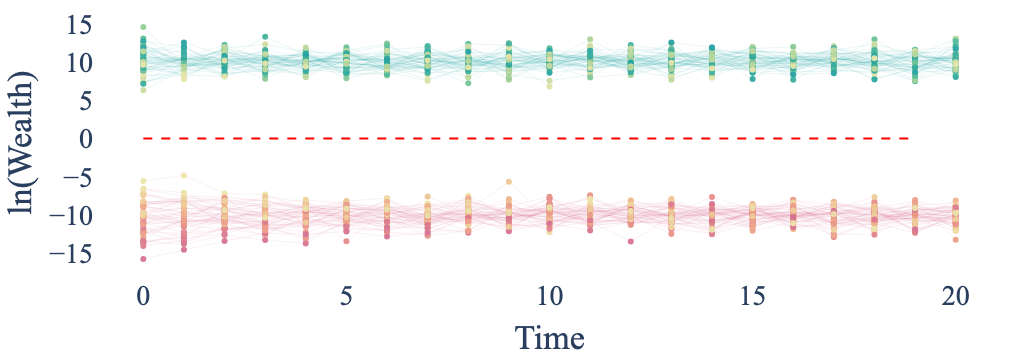

In [68]:
fig = go.Figure()


df_high = df_scenario5[df_scenario5['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario5[df_scenario5['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario5['Time'], 
    y=df_scenario5['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario5['Wealth_Rank_first'],  # Use Wealth_Rank globally
        colorscale='Temps', 
        # showscale=True, 
        # colorbar=dict(title="Wealth Rank")  
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario5['Time'], 
                         y=population_data5['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()


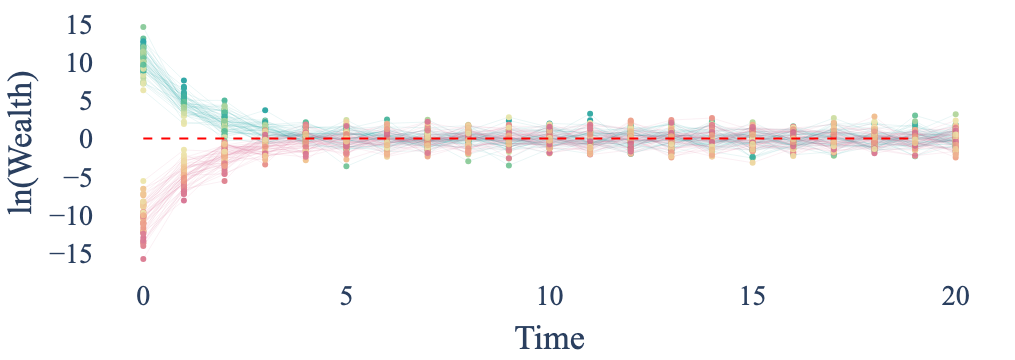

In [71]:
fig = go.Figure()


df_high = df_scenario6[df_scenario6['Group'] == 'high']
for i in df_high['Surname'].unique():
    df_nid = df_high[df_high['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (High)',
        opacity=0.1,
        line=dict(width=0.85, color='#009392')
    ))


df_low = df_scenario6[df_scenario6['Group'] == 'low']
for i in df_low['Surname'].unique():
    df_nid = df_low[df_low['Surname'] == i]
    fig.add_trace(go.Scatter(
        x=df_nid['Time'], 
        y=df_nid['log_Wealth_Random'], 
        mode='lines', 
        name=f'Surname {i} (Low)',
        opacity=0.1,
        line=dict(width=0.85, color='#cf597e')
    ))

fig.add_trace(go.Scatter(
    x=df_scenario6['Time'], 
    y=df_scenario6['log_Wealth_Random'], 
    mode='markers', 
    name='All Surnames',
    opacity=0.8,
    marker=dict(
        color=df_scenario6['Wealth_Rank_first'],  # Use Wealth_Rank globally
        colorscale='Temps',  # Continuous color scale
        # showscale=True,  # Display the color scale
        # colorbar=dict(title="Wealth Rank")  # Title for the color scale
    )
))


# Add the trace for the 'mu' line
fig.add_trace(go.Scatter(x=df_scenario6['Time'], 
                         y=population_data6['mu'],
                         mode='lines', 
                         name='mu', 
                         line=dict(color='red', dash='dash', width=2)))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='ln(Wealth)',
    legend_title='Surnames',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size = 28,
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()
